In [7]:
import os 
import time 
import json 
import torch 
import random 
import warnings
import torchvision
import numpy as np 
import pandas as pd 

from utils import *
from data import HumanDataset
from tqdm import tqdm 
from config import config
from datetime import datetime
from models.model import *
from models.RGB_RB_attn_model import RGB_RB_attn_bninception
from torch import nn,optim
from collections import OrderedDict
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import f1_score
from torchvision import transforms as T
from imgaug import augmenters as iaa
import math
from sklearn.model_selection import KFold

def getMaxF1Thr(preds, labels):
    """
    Return the threshold which can get max f1 value
    """
    AUC_list = np.zeros([101])
    max_f1_rate = 0
    max_f1, max_f1_thr = 0, 1
    f1_list, thr_list = list(), list()
    f1_sum, thr_sum = 0, 0
    f1_num, thr_num = 0, 0
    max_acc, max_acc_thr = 0, 1
    acc_list, acc_thr_list = list(), list()
    acc_sum, acc_thr_sum = 0, 0
    acc_num, acc_thr_num = 0, 0
    TP = 0
    TN = (labels == 0).sum()
    FP = 0
    FN = (labels == 1).sum()
    num = 100#len(preds) / 1000 + 1
    idx_big_small = np.argsort(-preds)
    count = 0
    for idx in idx_big_small:
        count += 1
        if (labels[idx] == 1):
            TP += 1
            FN -= 1
        if (labels[idx] == 0):
            TN -= 1
            FP += 1
        thr = preds[idx]
        precision = TP / (TP + FP + 0.001)
        recall = TP / (TP + FN + 0.001)
        if AUC_list[int(recall * 100)] < precision:
            AUC_list[int(recall * 100)] = precision
        f1 = (2 * precision * recall / (precision + recall + 0.001))
        f1_sum += f1
        thr_sum += thr
        f1_num += 1
        thr_num += 1
        f1_list.append(f1)
        thr_list.append(thr)
        
        accuracy = (TP + TN) / len(labels)
        acc_sum += accuracy
        acc_thr_sum += thr
        acc_num += 1
        acc_thr_num += 1
        acc_list.append(accuracy)
        acc_thr_list.append(thr)
        if f1_num > num:
            remove_f1 = f1_list.pop(0)
            remove_thr = thr_list.pop(0)
            f1_sum -= remove_f1
            thr_sum -= remove_thr
            f1_num -= 1
            thr_num -= 1
        if acc_num > num:
            remove_acc = acc_list.pop(0)
            remove_acc_thr = acc_thr_list.pop(0)
            acc_sum -= remove_acc
            acc_thr_sum -= remove_acc_thr
            acc_num -= 1
            acc_thr_num -= 1
        if (f1_sum / f1_num) > max_f1:
            max_f1 = f1_sum / f1_num
            max_f1_thr = thr_sum / thr_num
            max_f1_rate = (TP + FP) / (TP + FP + TN + FN)
        if (acc_sum / acc_num) > max_acc:
            max_acc = acc_sum / acc_num
            max_acc_thr = acc_thr_sum / acc_thr_num
    
    AUC_val = 0
    max_precision = 0
    for i in range(100, -1, -1):
        if max_precision < AUC_list[i]:
            max_precision = AUC_list[i]
        AUC_val += max_precision
    AUC_val /= 101
    
    return max_f1, max_f1_thr, max_acc, max_acc_thr, AUC_val, max_f1_rate

def getGreatThrs(preds, labels):
    """
    Return the threshold for every class which can get max f1 value
    """
    avg_f1 = 0
    avg_AUC = 0
    f1_thr = list()
    acc_thr = list()
    cls_f1 = list()
    f1_rate = list()
    for i in range(28):
        max_f1 ,max_f1_thr, max_acc, max_acc_thr, AUC, max_f1_rate = getMaxF1Thr(preds[:, i], labels[:, i])
        print("id = {0} max_f1 = {1} f1_thr = {2} f1_rate = {3} AUC = {4}".format(i, max_f1, max_f1_thr, max_f1_rate, AUC))
        f1_rate.append(max_f1_rate)
        f1_thr.append(max_f1_thr)
        acc_thr.append(max_acc_thr)
        cls_f1.append(max_f1)
        avg_f1 += max_f1
        avg_AUC += AUC
    print("macro f1 = ", avg_f1 / 28)
    print("avg AUC = ", avg_AUC / 28)
    return f1_thr, acc_thr, cls_f1, f1_rate

def getPredAndLabel(model_name, fold_set):
    """
    Get id, label and predict value for val dataset
    """
    val_pred = []
    val_label = []
    for fold_k in fold_set:
        fold = "%s_%s"%(model_name, str(fold_k))
        fold_val_pred_list = pd.read_csv('./submit/%s/bestloss_submission_val_pred.csv'%(fold))
        fold_val_label_list = pd.read_csv('./submit/%s/bestloss_submission_val_label.csv'%(fold))
        val_pred.append(fold_val_pred_list)
        val_label.append(fold_val_label_list)
    
    val_pred = pd.concat(val_pred, ignore_index=True)
    val_label = pd.concat(val_label, ignore_index=True)

    preds = np.array(val_pred['Predicted'])
    preds_np = np.zeros((len(preds), 28))
    labels = np.array(val_label['Target'])
    labels_np = np.zeros((len(labels), 28))
    Ids = np.array(val_label['Id'])
    for i in range(len(preds)):
        pred = preds[i].split(' ')
        for j in range(len(pred)):
            preds_np[i, j] = float(pred[j])
        label = labels[i].split(' ')
        for j in label:
            labels_np[i, int(j)] = 1
    preds = preds_np 
    labels = labels_np
    return Ids, preds, labels

def getTestPred(model_name, fold_set):
    """
    Get predict value for test dataset
    """
    fold = "%s_%s"%(model_name, '0')
    sample_df = pd.read_csv('./submit/%s/bestloss_submission_test_pred.csv'%(fold))
    res = np.zeros([len(sample_df["Id"]), 28])
    for fold_k in fold_set: 
        fold = "%s_%s"%(model_name, str(fold_k))
        fold_pred_list = pd.read_csv('./submit/%s/bestloss_submission_test_pred.csv'%(fold))
        for i, line in enumerate(fold_pred_list["Predicted"]):
            preds = line.split(" ")
            for j, pred in enumerate(preds):
                pred = float(pred)
                res[i, j] += pred
    res /= len(fold_set)
    return res
    
def mySplit(N, kfoldN):
    """
    Because I augment image in val data, I need split my dataset same as before to prevent leak
    """
    res = []
    x = 0
    y = 0
    for i in range(kfoldN):
        val_data_list = pd.read_csv('./Train_Val_MultiLabel_KFold/Val_KFold_%s_%s.csv'%(kfoldN, str(i)))
        fold_num = len(val_data_list['Id'])
        y += fold_num
        res.append((list(range(0,x)) + list(range(y, N)), list(range(x, y))))
        x += fold_num
    return res

In [3]:
"""
Get predictions and labels for all models on the val data, and predictions on the test data
predicitons on val data: dataX[5 * val_data_number, 28 * model_number]
labels on val data: dataY[5 * val_data_number, 28]
predictions on test data: test_X[test_data_number, 28 * model_number]
"""
# ensemble model name
model_name_set = ["model_12_31", "model_1_2", "model_1_3", "model_1_4", "model_1_5", "model_1_6", "model_1_8", "model_1_9"]
# ensemble fold index
fold_set = [0, 1, 2, 3, 4]

data_preds_set = list()
data_labels_set = list()
test_preds_set = list()
for i, model_name in enumerate(model_name_set):
    Ids, data_preds, data_labels = getPredAndLabel(model_name, fold_set)
    data_preds_set.append(data_preds)
    data_labels_set.append(data_labels)
    test_preds = getTestPred(model_name, fold_set)
    test_preds_set.append(test_preds)

data_X = np.hstack((data_preds_set))
data_Y = data_labels
test_X = np.hstack((test_preds_set))

In [8]:
"""
For each class, train a model on data_X and data_Y.
use the model to get the prediction on test_X -> final_res
use the model to get the predictions and labels on official and external data -> data_pred, data_label
use the model to get the predictions and labels on official data -> kaggle_pred_set, kaggle_label_set
"""
from sklearn import linear_model
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV

sample_submission_df = pd.read_csv("../input/sample_submission.csv")
final_res = np.zeros([len(sample_submission_df["Id"]), config.num_classes])
data_pred = []
data_label = []
kaggle_pred_set = []
kaggle_label_set = []

kf = KFold(n_splits=config.kfoldN,shuffle=True,random_state=2050)
# column index for the same class
cls_col = np.array([i for i in range(0, data_X.shape[1], config.num_classes)])
for iterKF, (train_idx, val_idx) in enumerate(mySplit(data_X.shape[0], config.kfoldN)):#enumerate(kf.split(data_X)):
    print("iterKF = ", iterKF)
    train_X = data_X[train_idx]
    train_Y = data_Y[train_idx]
    val_X = data_X[val_idx]
    val_Y = data_Y[val_idx]
    val_pred = np.zeros(val_Y.shape)
    kaggle_idx = []
    for idx in val_idx:
        if Ids[idx][:5] == "train":
            kaggle_idx.append(idx)
    kaggle_X = data_X[kaggle_idx]
    kaggle_Y = data_Y[kaggle_idx]
    kaggle_pred = np.zeros(kaggle_Y.shape)
    
    for cls_i in range(config.num_classes):
        # linear regress
        #model = linear_model.LinearRegression()
        #model.fit(train_X[:, cls_col + cls_i], train_Y[:, cls_i])
        # ridge regress
        model = Ridge(alpha=4.0)
        model.fit(train_X[:, cls_col + cls_i], train_Y[:, cls_i])
        # XGBRegress
        #model = XGBRegressor(n_estimators=100, learning_rate=0.05)
        #model.fit(train_X[:, cls_col + cls_i], train_Y[:, cls_i], early_stopping_rounds=5, eval_set=[(val_X[:, cls_col + cls_i], val_Y[:, cls_i])], verbose=False)
        kaggle_pred[:, cls_i] = model.predict(kaggle_X[:, cls_col + cls_i])
        val_pred[:, cls_i] = model.predict(val_X[:, cls_col + cls_i])
        final_res[:, cls_i] += model.predict(test_X[:, cls_col + cls_i])
    data_pred.append(val_pred)
    data_label.append(val_Y)
    kaggle_pred_set.append(kaggle_pred)
    kaggle_label_set.append(kaggle_Y)
final_res /= config.kfoldN

iterKF =  0
iterKF =  1
iterKF =  2
iterKF =  3
iterKF =  4


In [9]:
"""
get threshold which can obtain max f1 value on data_pred(official and external) or on kaggle_pred(official)
"""
# official data
#data_pred_np = np.vstack((kaggle_pred_set))
#data_label_np = np.vstack((kaggle_label_set))
# official and external data
data_pred_np = np.vstack((data_pred))
data_label_np = np.vstack((data_label))

f1_thr, acc_thr, cls_f1, f1_rate = getGreatThrs(data_pred_np, data_label_np)

id = 0 max_f1 = 0.8393833343438045 f1_thr = 0.40960882815330263 f1_rate = 0.40698395124813114 AUC = 0.9047417994140631
id = 1 max_f1 = 0.8383863783332066 f1_thr = 0.41665326297519767 f1_rate = 0.025277257328866935 AUC = 0.8811509589868602
id = 2 max_f1 = 0.7895176594467961 f1_thr = 0.35743818143937767 f1_rate = 0.08949355589621302 AUC = 0.8509634035780131
id = 3 max_f1 = 0.7586773604332449 f1_thr = 0.2979741380000514 f1_rate = 0.030467552376085845 AUC = 0.7978900728541798
id = 4 max_f1 = 0.7845317629518975 f1_thr = 0.35460898293581067 f1_rate = 0.045908325290031984 AUC = 0.8478349278007323
id = 5 max_f1 = 0.6785375442304759 f1_thr = 0.3020618232897307 f1_rate = 0.04859336853460512 AUC = 0.7316241681566291
id = 6 max_f1 = 0.7030255364510779 f1_thr = 0.36796253656570244 f1_rate = 0.028936959442835784 AUC = 0.752638587666496
id = 7 max_f1 = 0.7760764173042858 f1_thr = 0.33643028373736095 f1_rate = 0.07899113344310074 AUC = 0.8342636857123022
id = 8 max_f1 = 0.8067864940863596 f1_thr = 0.2

In [10]:
from scipy import stats

def getGreatThrByLabelRate(data_pred_np, data_label_np, final_res):
    """
    The threshold is obtained by combining the prediction of the test data 
    and the prediction accuracy of the val data. 
    But the result proof it is not very useful
    """
    f1_thr = []
    f1_rate = []
    f1_sum = 0
    stats_norm = np.zeros([101])
    for i in range(101):
        stats_norm[i] = stats.norm(0, 1).pdf(i)
    for col_ind in range(data_pred_np.shape[1]):
        label0_count = np.zeros([101])
        label1_count = np.zeros([101])
        label0_rate = np.zeros([101])
        label1_rate = np.zeros([101])
        label0_norm_rate = np.zeros([101])
        label1_norm_rate = np.zeros([101])
        for row_ind in range(data_pred_np.shape[0]):
            pred = int(data_pred_np[row_ind, col_ind] * 100 // 1)
            pred = min(100, pred)
            pred = max(0, pred)
            if data_label_np[row_ind, col_ind] == 0:
                label0_count[pred] += 1
            else:
                label1_count[pred] += 1
        
        label0_rate = (label0_count) / (label0_count + label1_count + 0.0002)
        label1_rate = (label1_count) / (label0_count + label1_count + 0.0002)
        for i in range(101):
            for j in range(101):
                label0_norm_rate[i] += label0_count[j] * stats_norm[abs(i - j)]
                label1_norm_rate[i] += label1_count[j] * stats_norm[abs(i - j)]
            label0_norm_rate[i] = (label0_norm_rate[i]) / (label0_norm_rate[i] + label1_norm_rate[i])
            label1_norm_rate[i] = 1 - label0_norm_rate[i]
        
        res_count = np.zeros([101])
        for row_ind in range(final_res.shape[0]):
            pred = int(final_res[row_ind, col_ind] * 100 // 1)
            pred = min(100, pred)
            pred = max(0, pred)
            res_count[pred] += 1
        
        max_f1_thr = 1000000
        max_f1_val = 0
        max_precision = 0
        max_recall = 0
        max_rate = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for i in range(101):
            TN += res_count[i] * label0_norm_rate[i]
            FN += res_count[i] * label1_norm_rate[i]
        for i in range(100, -1, -1):
            label0_num = res_count[i] * label0_norm_rate[i]
            label1_num = res_count[i] * label1_norm_rate[i]
            
            TP += label1_num
            FN -= label1_num
            
            TN -= label0_num
            FP += label0_num
            
            precision = TP / (TP + FP + 0.001)
            recall = TP / (TP + FN + 0.001)
            f1 = (2 * precision * recall / (precision + recall + 0.001))
            if f1 > max_f1_val:
                max_f1_val = f1
                max_f1_thr = i / 100
                max_precision = precision
                max_recall = recall
                max_rate = (TP + FP) / (TP + FP + TN + FN)
        print("id = {0} f1 = {1} thr = {2}".format(col_ind, max_f1_val, max_f1_thr))
        f1_sum += max_f1_val
        f1_thr.append(max_f1_thr)
        f1_rate.append(max_rate)
    print("avg f1 = ", (f1_sum / data_pred_np.shape[1]))
    return f1_thr#, f1_rate
labelrate_f1_thr = getGreatThrByLabelRate(data_pred_np, data_label_np, final_res)

id = 0 f1 = 0.823929584079782 thr = 0.41
id = 1 f1 = 0.8222241040949575 thr = 0.42
id = 2 f1 = 0.7543605993401334 thr = 0.34
id = 3 f1 = 0.7470355635796891 thr = 0.3
id = 4 f1 = 0.7539096177154198 thr = 0.35
id = 5 f1 = 0.6615907313173698 thr = 0.3
id = 6 f1 = 0.5804799079034692 thr = 0.3
id = 7 f1 = 0.7268237439811451 thr = 0.33
id = 8 f1 = 0.6857405843501836 thr = 0.52
id = 9 f1 = 0.6180787833750222 thr = 0.33
id = 10 f1 = 0.5091773034723157 thr = 0.33
id = 11 f1 = 0.7426309402412278 thr = 0.28
id = 12 f1 = 0.7055787372790849 thr = 0.37
id = 13 f1 = 0.7408964550220606 thr = 0.3
id = 14 f1 = 0.8175028431479298 thr = 0.4
id = 15 f1 = 0.39655345427660205 thr = 0.64
id = 16 f1 = 0.5457374659931175 thr = 0.31
id = 17 f1 = 0.6251260057571829 thr = 0.28
id = 18 f1 = 0.5963341453254868 thr = 0.27
id = 19 f1 = 0.6296102857126719 thr = 0.25
id = 20 f1 = 0.683834208037033 thr = 0.26
id = 21 f1 = 0.6641631360841329 thr = 0.31
id = 22 f1 = 0.6206245069028475 thr = 0.26
id = 23 f1 = 0.748210589517

In [11]:
def ClsByThr(labels, res_thr):
    """
    Output classify result by threshold
    """
    labels = labels.copy()
    for i, label in enumerate(labels):
        max_label_index, max_label_predict = 0, 0
        flag = 0
        for j in range(28):
            if labels[i][j] > max_label_predict:
                max_label_predict = labels[i][j]
                max_label_index = j
            if labels[i][j] > res_thr[j]:
                labels[i][j] = 1
                flag = 1
            else:
                labels[i][j] = 0    
        if flag == 0:
            labels[i][max_label_index] = 1
    return labels

if not os.path.exists('./submit/ensemble_pred'):
    os.makedirs('./submit/ensemble_pred')

res_thr = [i * 0.5 for i in f1_thr]
final = ClsByThr(final_res, res_thr)

submissions = []
for row in final:
    subrow = ' '.join(list([str(i) for i in np.nonzero(row)[0]]))
    submissions.append(subrow)
sample_submission_df['Predicted'] = submissions
sample_submission_df.to_csv('./submit/ensemble_pred/bestloss_submission_%s_pred.csv'%(model_name), index=None)

col_ind = 0 f1_thr = 0.41 cls_f1 = 0.8393833343438045


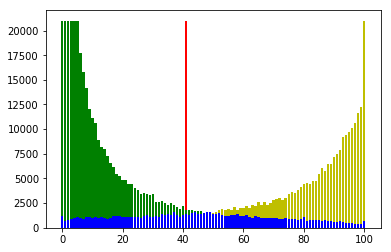

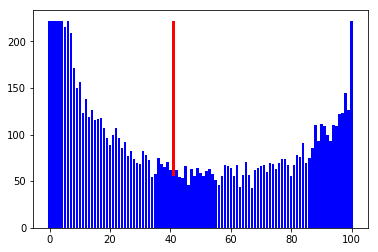

col_ind = 1 f1_thr = 0.42 cls_f1 = 0.8383863783332066


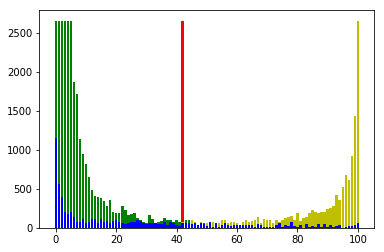

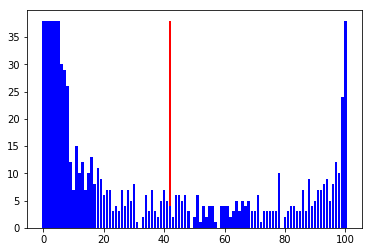

col_ind = 2 f1_thr = 0.34 cls_f1 = 0.7895176594467961


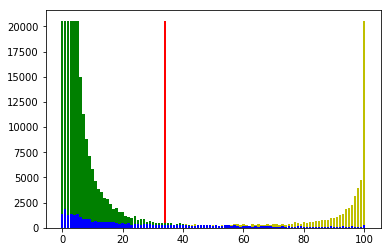

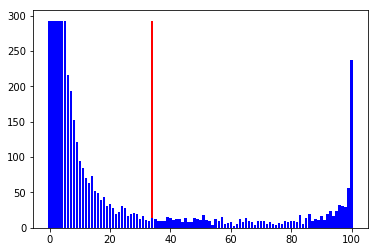

col_ind = 3 f1_thr = 0.3 cls_f1 = 0.7586773604332449


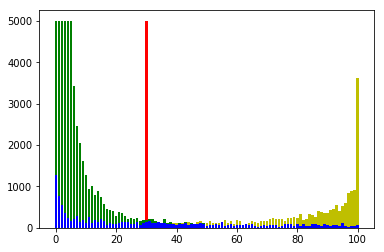

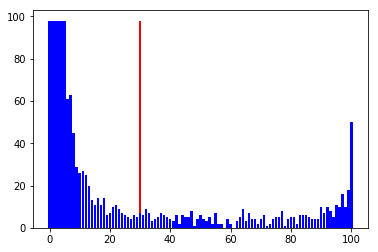

col_ind = 4 f1_thr = 0.35 cls_f1 = 0.7845317629518975


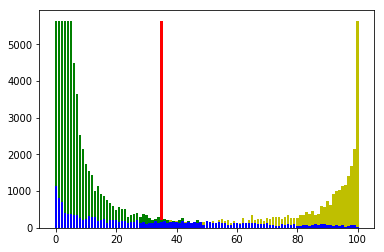

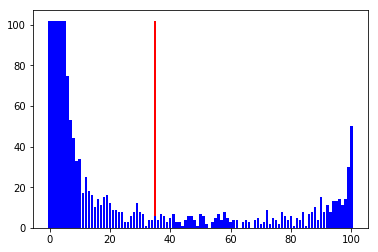

col_ind = 5 f1_thr = 0.3 cls_f1 = 0.6785375442304759


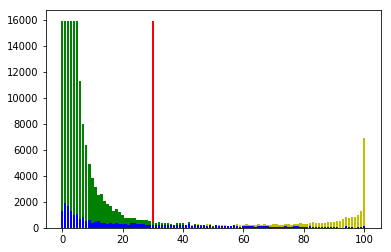

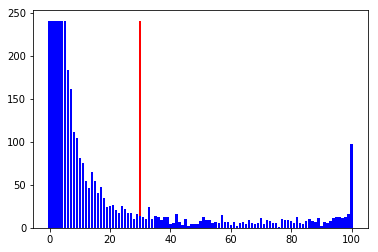

col_ind = 6 f1_thr = 0.3 cls_f1 = 0.7030255364510779


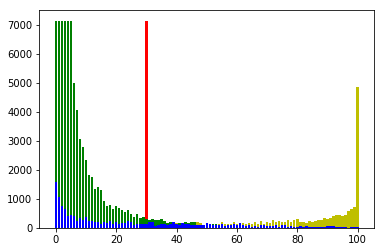

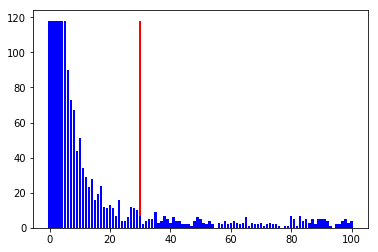

col_ind = 7 f1_thr = 0.33 cls_f1 = 0.7760764173042858


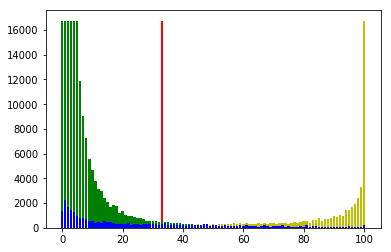

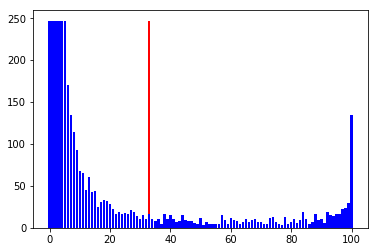

col_ind = 8 f1_thr = 0.52 cls_f1 = 0.8067864940863596


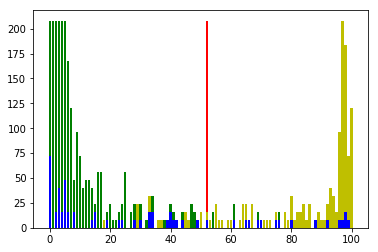

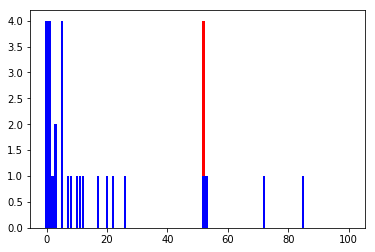

col_ind = 9 f1_thr = 0.33 cls_f1 = 0.6882555299445898


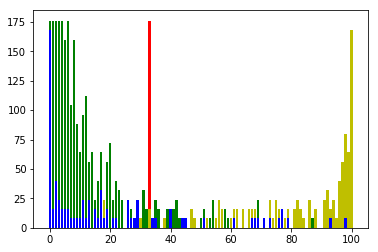

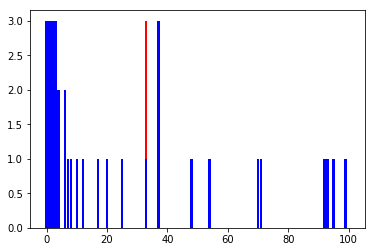

col_ind = 10 f1_thr = 0.33 cls_f1 = 0.589359315131136


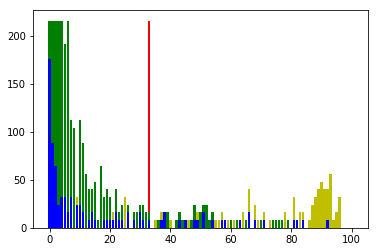

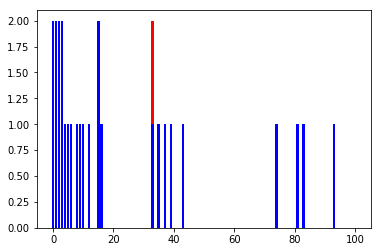

col_ind = 11 f1_thr = 0.28 cls_f1 = 0.7414087434265367


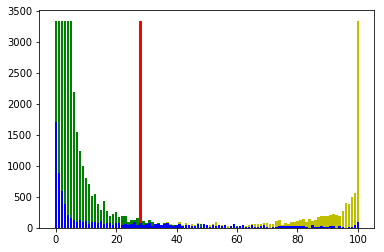

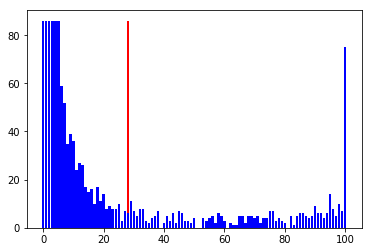

col_ind = 12 f1_thr = 0.37 cls_f1 = 0.7288369715084835


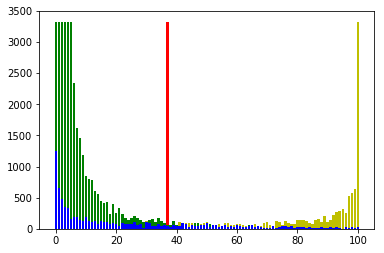

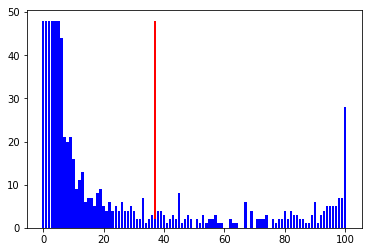

col_ind = 13 f1_thr = 0.3 cls_f1 = 0.6993217077970969


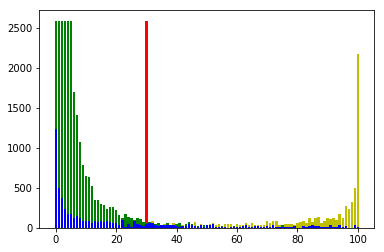

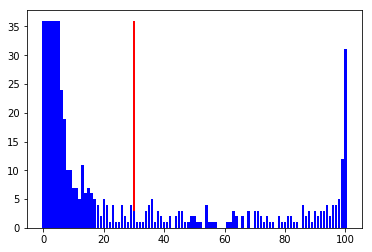

col_ind = 14 f1_thr = 0.4 cls_f1 = 0.8484092437540065


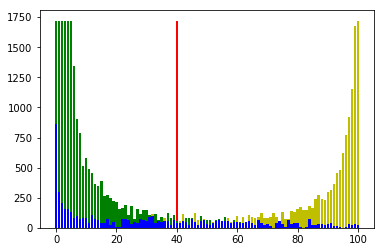

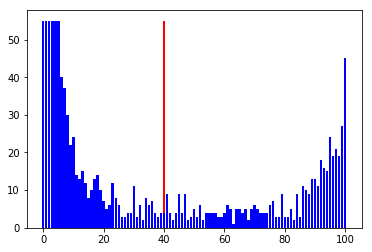

col_ind = 15 f1_thr = 0.64 cls_f1 = 0.45834567401561993


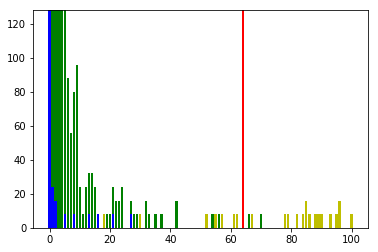

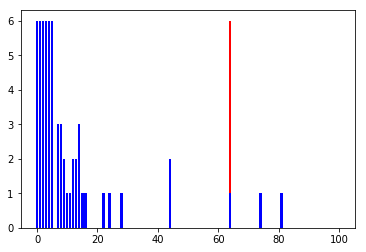

col_ind = 16 f1_thr = 0.31 cls_f1 = 0.47215819934491166


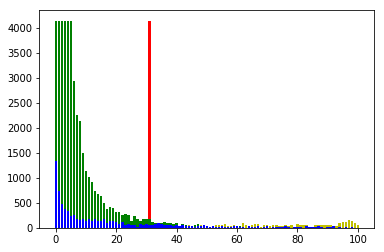

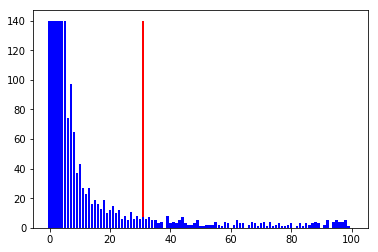

col_ind = 17 f1_thr = 0.28 cls_f1 = 0.5073314061226224


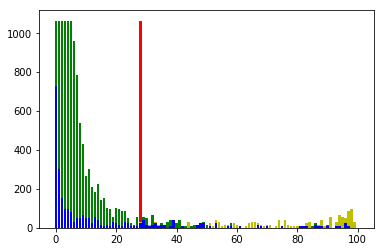

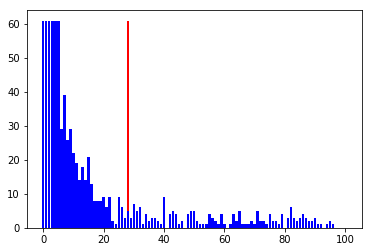

col_ind = 18 f1_thr = 0.27 cls_f1 = 0.572927177582767


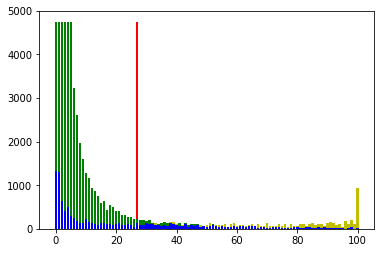

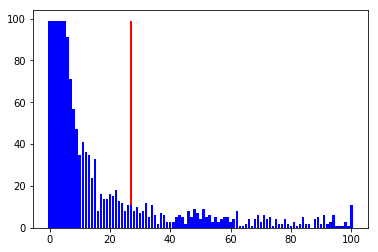

col_ind = 19 f1_thr = 0.25 cls_f1 = 0.6575769508881589


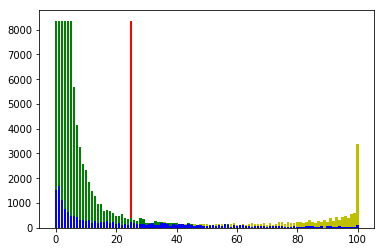

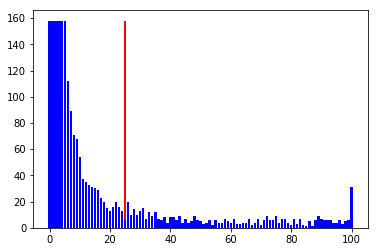

col_ind = 20 f1_thr = 0.26 cls_f1 = 0.6659335161043062


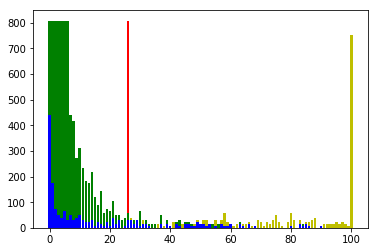

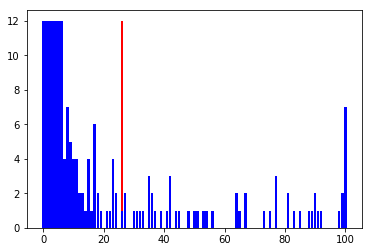

col_ind = 21 f1_thr = 0.31 cls_f1 = 0.6903094466183873


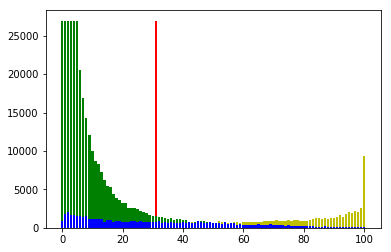

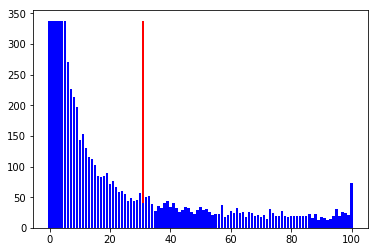

col_ind = 22 f1_thr = 0.26 cls_f1 = 0.6119327859038386


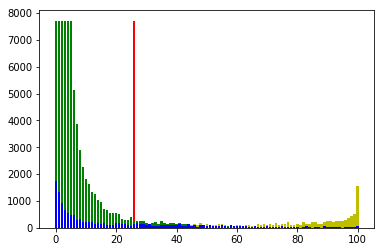

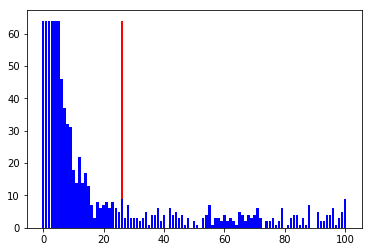

col_ind = 23 f1_thr = 0.39 cls_f1 = 0.84487236307613


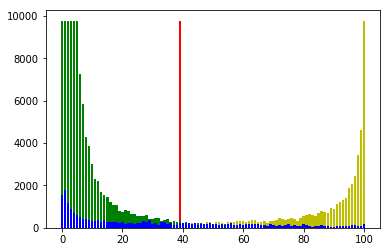

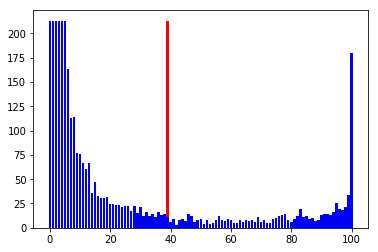

col_ind = 24 f1_thr = 0.19 cls_f1 = 0.6489026908511506


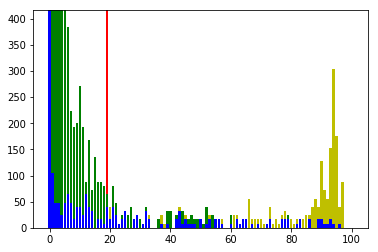

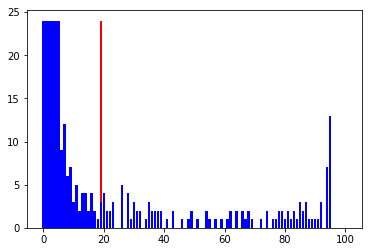

col_ind = 25 f1_thr = 0.35 cls_f1 = 0.7679270515586513


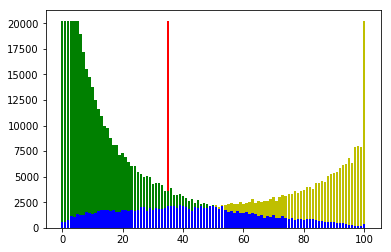

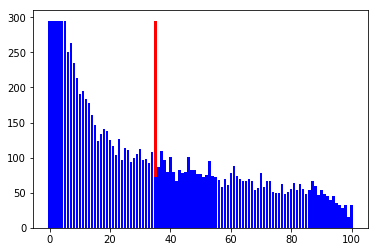

col_ind = 26 f1_thr = 0.32 cls_f1 = 0.5495156628541003


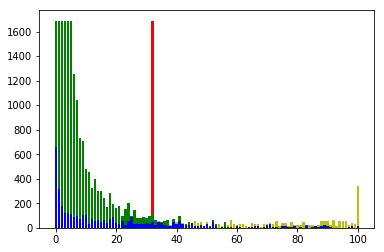

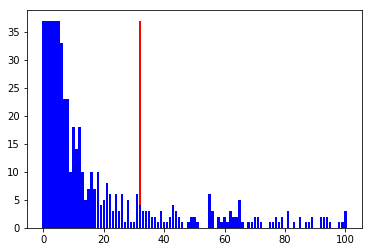

col_ind = 27 f1_thr = 0.24 cls_f1 = 0.5304521888741706


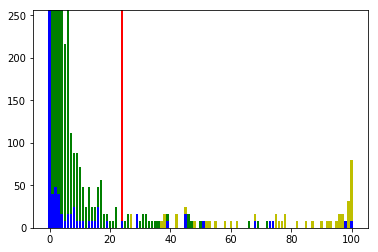

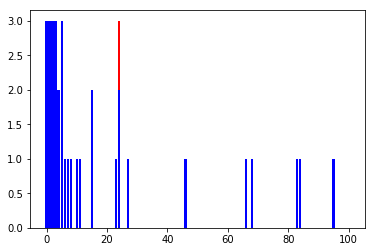

In [13]:
import matplotlib.pyplot as plt

def showPredAndLabel(final_res, data_pred_np, data_label_np, f1_thr, cls_f1):
    """
    The histogram shows the prediction accuracy rate of the val data
    and the predicted distribution of the test data
    """
    for col_ind in range(data_pred_np.shape[1]):
        print("col_ind = {0} f1_thr = {1} cls_f1 = {2}".format(col_ind, f1_thr[col_ind], cls_f1[col_ind]))
        label0_count = np.zeros([101])
        label1_count = np.zeros([101])
        for row_ind in range(data_pred_np.shape[0]):
            pred = int(data_pred_np[row_ind, col_ind] * 100)
            pred = min(100, pred)
            pred = max(0, pred)
            if data_label_np[row_ind, col_ind] == 0:
                label0_count[pred] += 1
            else:
                label1_count[pred] += 1
        max_label0 = max(label0_count[5:95])
        max_label1 = max(label1_count[5:95])
        max_label0 = max(max_label0, max_label1)
        max_label1 = max(max_label0, max_label1)
        label0_count[0:5] = np.array([min(label0_count[i], max_label0) for i in range(0, 5)])
        label0_count[95:101] = np.array([min(label0_count[i], max_label0) for i in range(95, 101)])
        label1_count[0:5] = np.array([min(label1_count[i], max_label1) for i in range(0, 5)])
        label1_count[95:101] = np.array([min(label1_count[i], max_label1) for i in range(95, 101)])
        f1_thr_count = np.zeros([101])
        f1_thr_count[int(f1_thr[col_ind] * 100)] = max_label0
        
        label01_count = np.array([min(label0_count[i], label1_count[i]) for i in range(101)])
        label0_count -= label01_count
        label1_count -= label01_count
        plt.bar(range(len(f1_thr_count)), f1_thr_count, fc='r')
        plt.bar(range(len(label01_count)), label01_count, fc='b')
        plt.bar(range(len(label0_count)), label0_count, bottom=label01_count, fc='g')
        plt.bar(range(len(label1_count)), label1_count, bottom=label01_count, fc='y')
        plt.show()
        
        res_count = np.zeros([101])
        for row_ind in range(final_res.shape[0]):
            pred = int(final_res[row_ind, col_ind] * 100)
            pred = min(100, pred)
            pred = max(0, pred)
            res_count[pred] += 1
        max_res = max(res_count[5:95])
        res_count[0:5] = np.array([min(res_count[i], max_res) for i in range(0, 5)])
        res_count[95:101] = np.array([min(res_count[i], max_res) for i in range(95, 101)])
        f1_thr_count = np.zeros([101])
        f1_thr_count[int(f1_thr[col_ind] * 100)] = max_res
        plt.bar(range(len(f1_thr_count)), f1_thr_count, fc='r')
        plt.bar(range(len(res_count)), res_count, fc='b')
        plt.show()

showPredAndLabel(final_res, data_pred_np, data_label_np, labelrate_f1_thr, cls_f1)